In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install tensorflow_gpu==1.15.2

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 410.9 MB 33 kB/s 
     |████████████████████████████████| 3.8 MB 56.3 MB/s 
     |████████████████████████████████| 503 kB 71.1 MB/s 
     |████████████████████████████████| 50 kB 8.3 MB/s 
  Created wheel for gast: filename=gast-0.2.2-py3-none-any.whl size=7554 sha256=2cf201239253c0619f28a1753d8663d3c26eaf2ece948f427ed5d06d590f6421
  Stored in directory: /root/.cache/pip/wheels/21/7f/02/420f32a803f7d0967b48dd823da3f558c5166991bfd204eef3
Successfully built gast
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.9.0
    Uninstalling tensorflow-estimator-2.9.0:
      Successfully uninstalled tensorflow-estimator-2.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.9.1
    Uninstalling tensorboard-2.9.1:
      Successfully uninstalled tensorboard-2.9.1
  Attempting un

In [3]:
# import necessary libraries and modules ...

import tensorflow as tf
import numpy as np
import time
import matplotlib
matplotlib.rc('image', cmap='jet') 
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
!pip install pydoe
from pyDOE import lhs

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Created wheel for pydoe: filename=pyDOE-0.3.8-py3-none-any.whl size=18184 sha256=f655d6b5edaca3c15696461ee9272c21de20d050471014c671bca0c9f962846d
  Stored in directory: /root/.cache/pip/wheels/83/ce/8a/87b25c685bfeca1872d13b8dc101e087a9c6e3fb5ebb47022a
Successfully built pydoe


In [5]:
# for reproducibility ...

tf.random.set_random_seed(1234)
np.random.seed(1234)

In [6]:
# change your path here...
observed_tau = pd.read_csv('/content/drive/MyDrive/pinn_new_test_models/new_model4_observed_tau.csv',header=None)
observed_tau = observed_tau.values

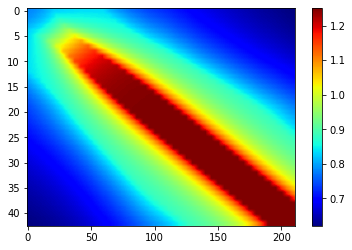

In [7]:
plt.imshow(observed_tau,aspect='auto')
plt.colorbar()

In [79]:
velocity_model = pd.read_csv('/content/drive/MyDrive/pinn_new_test_models/new_modelexamp4.csv',header=None)
velocity_model = velocity_model.values

In [6]:
# change your path here...
observed_tau = pd.read_csv('/content/drive/MyDrive/pinn_new_test_models/new_model4_observed_tau_layered.csv',header=None)
observed_tau = observed_tau.values

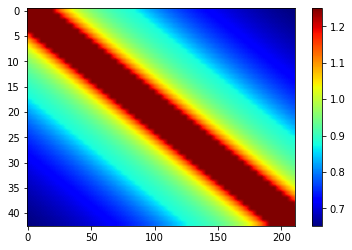

In [7]:
plt.imshow(observed_tau,aspect='auto')
plt.colorbar()

In [8]:
three_well = pd.read_csv('/content/drive/MyDrive/pinn_new_test_models/three_well_model4.csv',header=None)
three_well = three_well.values

In [8]:
four_well = pd.read_csv('/content/drive/MyDrive/pinn_new_test_models/four_well_model4.csv',header=None)
four_well = four_well.values

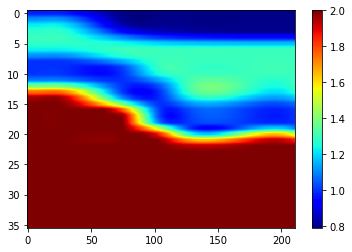

In [9]:
plt.imshow(four_well,aspect='auto')
plt.colorbar()

network for learning observed tau

In [10]:
shot_num = 43
rec_num = 211 
source_shift = 0.05


In [94]:
tau_d_train = observed_tau.flatten()
tau_d_train = tau_d_train[:,None]

In [95]:
# create source coordinates for training data

# create source data for the first shot
xst = np.array([0])
xst = np.tile(xst,rec_num)

# create source data for the others
for sn in np.arange(source_shift, 2.1 +source_shift, source_shift): 

  sn = np.round(sn,2) # use 2 as source shift is 0.05
  rep = np.array([sn])
  rep = np.tile(rep,rec_num)
  xst = np.concatenate((xst,rep))
yst = np.zeros(len(xst)) # surface y coordinates are all 0

Xst = xst[:,None] # corresponds to tau_d_train
Yst = yst[:,None] # corresponds to tau_d_train

In [96]:
# create x and y coordinates corresponds the training data
xtrain = np.arange(0,2.11,0.01) # receiver coordinates 
ytrain = np.zeros(len(xtrain)) # surface y coordinates are all 0

xtrain_rep = np.tile(xtrain,shot_num)
ytrain_rep = np.zeros(len(xtrain_rep)) # surface y coordinates are all 0
X_train = xtrain_rep[:,None] # corresponds to tau_d_train
Y_train = ytrain_rep[:,None] # corresponds to tau_d_train

In [97]:
class Surface_tau:
    # Initialize the class
    def __init__(self, x_e, xse, T_e, layers, CVlayers, jobs = 4):
        

        X = np.concatenate([x_e, xse], 1)


        self.lb = X.min(0)
        self.ub = X.max(0)
                
        self.X = X

        self.xse = xse

        self.T_e = T_e
        self.x_e = x_e
    
        
        self.layers = layers
        self.CVlayers = CVlayers
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)


        # initialize the velocity NN weights.
        self.CVweights, self.CVbiases = self.initialize_NN(CVlayers) 

        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True,
                                                     intra_op_parallelism_threads=jobs,
                                                     inter_op_parallelism_threads=jobs,
                                                     device_count={'CPU': jobs}))
        
        self.xse_tf = tf.placeholder(tf.float32, shape=[None, self.xse.shape[1]])
        
        self.T_e_tf = tf.placeholder(tf.float32, shape=[None, self.T_e.shape[1]]) 
        self.x_e_tf = tf.placeholder(tf.float32, shape=[None, self.x_e.shape[1]]) 

      
                
        self.T_e_pred = self.net_eikonal(self.x_e_tf, self.xse_tf)


        self.loss = tf.reduce_mean(tf.square(self.T_e_tf - self.T_e_pred)) 
    
     
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss, var_list= self.weights + self.biases) 
        # Define optimizer (use L-BFGS for faster convergence)       
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                var_list= self.weights + self.biases,
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 10000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})

        
        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)


    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):      
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev, dtype=tf.float32)   
        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        
        
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

  


    def net_eikonal(self,x,xsource):
        T = self.neural_net(tf.concat([x,xsource], 1), self.weights, self.biases)
        return T
        

    
    def callback(self, loss):
        self.lossit.append(loss)
        print('Loss: %.5e' % (loss))
      
    def train(self): 

        tf_dict = {self.x_e_tf: self.x_e, self.xse_tf: self.xse, self.T_e_tf: self.T_e}
        
        # Call SciPy's L-BFGS otpimizer
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)
        
    def train_Adam(self, nIter): 
        
        self.lossit = []
        tf_dict = {self.x_e_tf: self.x_e, self.xse_tf: self.xse, self.T_e_tf: self.T_e}          

        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            loss_value = self.sess.run(self.loss, tf_dict)
            self.lossit.append(loss_value)

            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
            
        #self.optimizer.minimize(self.sess,
        #                        feed_dict = tf_dict,
        #                        fetches = [self.loss],
        #                        loss_callback = self.callback)
        return self.lossit
        


    #def train_Adam_minibatch(self, nIter, size = 50): 
        
    #    self.lossit = []
       
    #    start_time = time.time()
    #    for it in range(nIter):
    #        X = lhs(2, size)
    #        XS = np.random.choice(np.arange(0, 2.1 + 0.05, 0.05),size)[:,None]
    #        #tf_dict = {self.x_tf: 2.11*X[:,:1], self.y_tf: 0.36*X[:,1:], self.xsource_tf: XS,
    #        #        self.x_e_tf: self.x_e, self.y_e_tf: self.y_e, self.xse_tf: self.xse, self.T_e_tf: self.T_e}  
    #        tf_dict = {self.x_tf: 2.11*X[:,:1], self.y_tf: 0.36*X[:,1:], self.xsource_tf: XS,  self.xswell_tf: self.xswell, self.xwell_tf: self.xwell, self.ywell_tf: self.ywell,
    #                   self.x_e_tf: self.x_e, self.y_e_tf: self.y_e, self.xse_tf: self.xse, self.T_e_tf: self.T_e, self.Vwell_tf: self.Vwell}   
    #        self.sess.run(self.train_op_Adam, tf_dict)
    #        loss_value = self.sess.run(self.loss, tf_dict)
    #        self.lossit.append(loss_value)

            # Print
    #        if it % 10 == 0:
    #            elapsed = time.time() - start_time
    #            C_value = np.exp(self.sess.run(self.C))
    #            print('It: %d, Loss: %.3e, C: %.3f, Time: %.2f' % 
    #                  (it, loss_value, C_value, elapsed))
    #            start_time = time.time()  

    #    return self.lossit                       
            
    def predict(self, x_star, xsource_star):
        
        
        tf_dict = {self.x_e_tf: x_star, self.xse_tf: xsource_star} 

        tau_d = self.sess.run(self.T_e_pred, tf_dict)
        NNtweights = self.sess.run(self.weights, tf_dict)
        NNtbiases = self.sess.run(self.biases, tf_dict)

        return tau_d, NNtweights, NNtbiases

In [98]:
#########################    CALLING THE CLASS  ###############################
layers =   [2,50,50,50,50,50,1]
CVlayers = [2,50,50,50,50,50,1] # not used


model = Surface_tau(X_train, Xst, tau_d_train, layers, CVlayers)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [101]:
#saved_loss = model.train_Adam(50000)
saved_loss_LBFGS = model.train() # BFGS training

Loss: 9.55803e-07


In [102]:
tau_d, NNtweights, NNtbiases  = model.predict(X_train,Xst)

In [105]:
import pickle

In [106]:
with open('NNtweights', 'wb') as handle: 
   pickle.dump(NNtweights, handle)  
with open('NNtbiases', 'wb') as handle: 
   pickle.dump(NNtbiases, handle)  

In [103]:
tau_d_est = tau_d[(21*211): 22* 211,:]

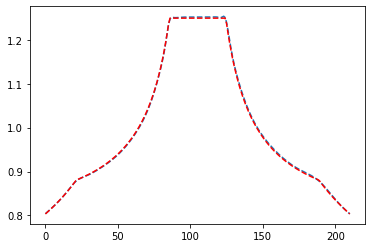

In [20]:
plt.plot(tau_d_est,'--')
plt.plot(observed_tau[21],'r--')

network for learning observed tau derivative

In [ ]:
tau_derivative = np.gradient(observed_tau,0.01)
tau_derivative = tau_derivative[1]
tau_dx_train = tau_derivative.flatten()
tau_dx_train = tau_dx_train[:,None]

In [ ]:
# create source coordinates for training data

# create source data for the first shot
xst = np.array([0])
xst = np.tile(xst,rec_num)

# create source data for the others
for sn in np.arange(source_shift, 2.1 +source_shift, source_shift): 

  sn = np.round(sn,2) # use 2 as source shift is 0.05
  rep = np.array([sn])
  rep = np.tile(rep,rec_num)
  xst = np.concatenate((xst,rep))
yst = np.zeros(len(xst)) # surface y coordinates are all 0

Xst = xst[:,None] # corresponds to tau_dx_train
Yst = yst[:,None] # corresponds to tau_dx_train

In [ ]:
# create x and y coordinates corresponds the training data
xtrain = np.arange(0,2.11,0.01) # receiver coordinates 
ytrain = np.zeros(len(xtrain)) # surface y coordinates are all 0

xtrain_rep = np.tile(xtrain,shot_num)
ytrain_rep = np.zeros(len(xtrain_rep)) # surface y coordinates are all 0
X_train = xtrain_rep[:,None] # corresponds to tau_dx_train
Y_train = ytrain_rep[:,None] # corresponds to tau_dx_train

In [ ]:
class tau_der:
    # Initialize the class
    def __init__(self, x_e, xse, T_e, layers, CVlayers, jobs = 4):
        

        X = np.concatenate([x_e, xse], 1)


        self.lb = X.min(0)
        self.ub = X.max(0)
                
        self.X = X

        self.xse = xse

        self.T_e = T_e
        self.x_e = x_e
    
        
        self.layers = layers
        self.CVlayers = CVlayers
        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers)


        # initialize the velocity NN weights.
        self.CVweights, self.CVbiases = self.initialize_NN(CVlayers) 

        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True,
                                                     intra_op_parallelism_threads=jobs,
                                                     inter_op_parallelism_threads=jobs,
                                                     device_count={'CPU': jobs}))
        
        self.xse_tf = tf.placeholder(tf.float32, shape=[None, self.xse.shape[1]])
        
        self.T_e_tf = tf.placeholder(tf.float32, shape=[None, self.T_e.shape[1]]) 
        self.x_e_tf = tf.placeholder(tf.float32, shape=[None, self.x_e.shape[1]]) 

      
                
        self.T_e_pred = self.net_eikonal(self.x_e_tf, self.xse_tf)


        self.loss = tf.reduce_mean(tf.square(self.T_e_tf - self.T_e_pred)) 
    
     
        self.optimizer_Adam = tf.train.AdamOptimizer()
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss, var_list= self.weights + self.biases) 
        # Define optimizer (use L-BFGS for faster convergence)       
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                var_list= self.weights + self.biases,
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 10000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})

        
        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)


    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):      
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random_normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev, dtype=tf.float32)   
        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        
        
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

  


    def net_eikonal(self,x,xsource):
        T = self.neural_net(tf.concat([x,xsource], 1), self.weights, self.biases)
        return T
        

    
    def callback(self, loss):
        self.lossit.append(loss)
        print('Loss: %.5e' % (loss))
      
    def train(self): 

        tf_dict = {self.x_e_tf: self.x_e, self.xse_tf: self.xse, self.T_e_tf: self.T_e}
        
        # Call SciPy's L-BFGS otpimizer
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)
        
    def train_Adam(self, nIter): 
        
        self.lossit = []
        tf_dict = {self.x_e_tf: self.x_e, self.xse_tf: self.xse, self.T_e_tf: self.T_e}          

        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            loss_value = self.sess.run(self.loss, tf_dict)
            self.lossit.append(loss_value)

            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                      (it, loss_value, elapsed))
                start_time = time.time()
            
        #self.optimizer.minimize(self.sess,
        #                        feed_dict = tf_dict,
        #                        fetches = [self.loss],
        #                        loss_callback = self.callback)
        return self.lossit
        


    #def train_Adam_minibatch(self, nIter, size = 50): 
        
    #    self.lossit = []
       
    #    start_time = time.time()
    #    for it in range(nIter):
    #        X = lhs(2, size)
    #        XS = np.random.choice(np.arange(0, 2.1 + 0.05, 0.05),size)[:,None]
    #        #tf_dict = {self.x_tf: 2.11*X[:,:1], self.y_tf: 0.36*X[:,1:], self.xsource_tf: XS,
    #        #        self.x_e_tf: self.x_e, self.y_e_tf: self.y_e, self.xse_tf: self.xse, self.T_e_tf: self.T_e}  
    #        tf_dict = {self.x_tf: 2.11*X[:,:1], self.y_tf: 0.36*X[:,1:], self.xsource_tf: XS,  self.xswell_tf: self.xswell, self.xwell_tf: self.xwell, self.ywell_tf: self.ywell,
    #                   self.x_e_tf: self.x_e, self.y_e_tf: self.y_e, self.xse_tf: self.xse, self.T_e_tf: self.T_e, self.Vwell_tf: self.Vwell}   
    #        self.sess.run(self.train_op_Adam, tf_dict)
    #        loss_value = self.sess.run(self.loss, tf_dict)
    #        self.lossit.append(loss_value)

            # Print
    #        if it % 10 == 0:
    #            elapsed = time.time() - start_time
    #            C_value = np.exp(self.sess.run(self.C))
    #            print('It: %d, Loss: %.3e, C: %.3f, Time: %.2f' % 
    #                  (it, loss_value, C_value, elapsed))
    #            start_time = time.time()  

    #    return self.lossit                       
            
    def predict(self, x_star, xsource_star):
        
        
        tf_dict = {self.x_e_tf: x_star, self.xse_tf: xsource_star} 

        tau_derivative = self.sess.run(self.T_e_pred, tf_dict)
        NNdtauweights = self.sess.run(self.weights, tf_dict)
        NNdtaubiases = self.sess.run(self.biases, tf_dict)

        return tau_derivative, NNdtauweights, NNdtaubiases

In [ ]:
#########################    CALLING THE CLASS  ###############################
layers = [2,50,50,50,50,50,50,50,1]
CVlayers = [2,50,50,50,50,50,1] # not used


model = tau_der(X_train, Xst, tau_dx_train, layers, CVlayers)

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



In [ ]:
saved_loss = model.train_Adam(50000)

It: 0, Loss: 5.268e-02, Time: 0.36
It: 10, Loss: 4.562e-02, Time: 0.64
It: 20, Loss: 4.305e-02, Time: 0.52
It: 30, Loss: 4.298e-02, Time: 0.52
It: 40, Loss: 4.283e-02, Time: 0.52
It: 50, Loss: 4.247e-02, Time: 0.53
It: 60, Loss: 4.212e-02, Time: 0.51
It: 70, Loss: 4.177e-02, Time: 0.55
It: 80, Loss: 4.144e-02, Time: 0.52
It: 90, Loss: 4.105e-02, Time: 0.52
It: 100, Loss: 4.052e-02, Time: 0.50
It: 110, Loss: 3.994e-02, Time: 0.55
It: 120, Loss: 3.936e-02, Time: 0.51
It: 130, Loss: 3.886e-02, Time: 0.53
It: 140, Loss: 3.834e-02, Time: 0.51
It: 150, Loss: 3.793e-02, Time: 0.52
It: 160, Loss: 3.815e-02, Time: 0.50
It: 170, Loss: 3.764e-02, Time: 0.53
It: 180, Loss: 3.746e-02, Time: 0.51
It: 190, Loss: 3.734e-02, Time: 0.53
It: 200, Loss: 3.716e-02, Time: 0.50
It: 210, Loss: 3.696e-02, Time: 0.53
It: 220, Loss: 3.674e-02, Time: 0.50
It: 230, Loss: 3.651e-02, Time: 0.53
It: 240, Loss: 3.632e-02, Time: 0.53
It: 250, Loss: 3.618e-02, Time: 0.50
It: 260, Loss: 3.608e-02, Time: 0.54
It: 270, Los

In [ ]:
tau_derivative, NNdtauweights, NNdtaubiases  = model.predict(X_train,Xst)


In [ ]:
import pickle

In [ ]:
with open('NNdtauweights', 'wb') as handle: 
   pickle.dump(NNdtauweights, handle)  
with open('NNdtaubiases', 'wb') as handle: 
   pickle.dump(NNdtaubiases, handle)  

# Hard constraint PINN (factored)

In [ ]:
# read weights and biases

In [11]:
import pickle

In [12]:
with open('NNdtauweights', 'rb') as f: 
   NNdtauweights = pickle.load(f) 
with open('NNdtaubiases', 'rb') as f: 
   NNdtaubiases = pickle.load(f) 
with open('NNtauweights', 'rb') as f: 
   NNtauweights = pickle.load(f) 
with open('NNtaubiases', 'rb') as f: 
   NNtaubiases = pickle.load(f) 
with open('NNt0weights', 'rb') as f: 
   NNt0weights = pickle.load(f) 
with open('NNt0biases', 'rb') as f: 
   NNt0biases = pickle.load(f) 

with open('NNwweights', 'rb') as f: 
   NNwweights = pickle.load(f)
with open('NNwbiases', 'rb') as f: 
   NNwbiases = pickle.load(f)


In [11]:
with open('NNvweights', 'rb') as f: 
   NNvweights = pickle.load(f)
with open('NNvbiases', 'rb') as f: 
   NNvbiases = pickle.load(f)

In [13]:
layers = [2,50,50,50,50,50,50,50,1]
def initial_dtNN_weights(layers, weights, biases):       
        dtweights = []
        dtbiases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = tf.Variable(tf.multiply(weights[l], 1), dtype=tf.float32)
            b = tf.Variable(tf.multiply(biases[l], 1), dtype=tf.float32)
            dtweights.append(W)
            dtbiases.append(b)        
        return dtweights, dtbiases

In [14]:
dtauweights, dtaubiases = initial_dtNN_weights(layers, NNdtauweights, NNdtaubiases)

In [15]:
layers = [2,50,50,50,50,50,1]
def initial_dtNN_weights(layers, weights, biases):       
        tauweights = []
        taubiases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = tf.Variable(tf.multiply(weights[l], 1), dtype=tf.float32)
            b = tf.Variable(tf.multiply(biases[l], 1), dtype=tf.float32)
            tauweights.append(W)
            taubiases.append(b)        
        return tauweights, taubiases

In [16]:
tauweights, taubiases = initial_dtNN_weights(layers, NNtauweights, NNtaubiases)

In [17]:
layers = [3,50,50,50,50,50,1]
def initial_t0NN_weights(layers, weights, biases):       
        t0weights = []
        t0biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = tf.Variable(tf.multiply(weights[l], 1), dtype=tf.float32)
            b = tf.Variable(tf.multiply(biases[l], 1), dtype=tf.float32)
            t0weights.append(W)
            t0biases.append(b)        
        return t0weights, t0biases

In [18]:
t0weights, t0biases = initial_t0NN_weights(layers, NNt0weights, NNt0biases)

In [19]:
#layers = [1,50,50,50,50,50,1] # one well
layers = [2,50,50,50,50,50,1] # more than one well
def initial_wNN_weights(layers, weights, biases):       
        wweights = []
        wbiases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = tf.Variable(tf.multiply(weights[l], 1), dtype=tf.float32)
            b = tf.Variable(tf.multiply(biases[l], 1), dtype=tf.float32)
            wweights.append(W)
            wbiases.append(b)        
        return wweights, wbiases

In [20]:
wweights, wbiases = initial_wNN_weights(layers, NNwweights, NNwbiases)

In [20]:
layers = [2,50,50,50,50,50,1] # for velocity correction factor/ initial velocity model
def initial_wNN_weights(layers, weights, biases):       
        wweights = []
        wbiases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = tf.Variable(tf.multiply(weights[l], 1), dtype=tf.float32)
            b = tf.Variable(tf.multiply(biases[l], 1), dtype=tf.float32)
            wweights.append(W)
            wbiases.append(b)        
        return wweights, wbiases

In [21]:
NNweights, NNbiases = initial_wNN_weights(layers, NNvweights, NNvbiases)

In [ ]:
############################################################################

In [21]:
x = np.arange(0,2.11,0.01)[:,None]
y = np.arange(0,0.36,0.01)[:,None]

X_m, Y_m = np.meshgrid(x,y)
X = X_m.flatten()
Y = Y_m.flatten()
X_predict = X_m.flatten()[:,None] # use for prediction
Y_predict = Y_m.flatten()[:,None] # use for prediction
X_rep = np.tile(X, shot_num)[:,None] # shot number times replecated X 
Y_rep = np.tile(Y, shot_num)[:,None] # shot number times replecated Y

In [22]:
###########
x = np.arange(0,2.11,0.01)[:,None]
y1 = np.arange(0.12,0.16,0.01)[:,None]
X_m1, Y_m1 = np.meshgrid(x,y1)
X1 = X_m1.flatten()
Y1 = Y_m1.flatten()
X_predict1 = X_m1.flatten()[:,None] # use for prediction
Y_predict1 = Y_m1.flatten()[:,None] # use for prediction
X_rep1 = np.tile(X1, shot_num)[:,None] # shot number times replecated X 
Y_rep1 = np.tile(Y1, shot_num)[:,None] # shot number times replecated Y

In [23]:
X_rep1.shape

(45365, 1)

In [24]:
##################
# create source data for the first shot
xs1 = np.array([0])
xs1 = np.tile(xs1,len(X1))

# create source data for the others
for sn in np.arange(source_shift, 2.1 + source_shift, source_shift):  
  sn = np.round(sn,2) # use 2 as source shift is 0.05
  rep1 = np.array([sn])
  rep1 = np.tile(rep1,len(X1))
  xs1 = np.concatenate((xs1,rep1))
ys1 = np.zeros(len(xs1)) # surface y coordinates are all 0

Xs1 = xs1[:,None] # corresponds to X_rep
Ys1 = ys1[:,None] # corresponds to Y_rep


In [ ]:
Xs1.shape

(45365, 1)

In [25]:
# create source data for the first shot
xs = np.array([0])
xs = np.tile(xs,len(X))

# create source data for the others
for sn in np.arange(source_shift, 2.1 + source_shift, source_shift):  
  sn = np.round(sn,2) # use 2 as source shift is 0.05
  rep = np.array([sn])
  rep = np.tile(rep,len(X))
  xs = np.concatenate((xs,rep))
ys = np.zeros(len(xs)) # surface y coordinates are all 0

Xs = xs[:,None] # corresponds to X_rep
Ys = ys[:,None] # corresponds to Y_rep


# saved class (hard constraint with factored eikonal)

In [299]:
class Pinn_hard_factored:
    # Initialize the class
    def __init__(self, x, y, xsource, layers, CVlayers, wlayers,  dtaulayers, taulayers, t0layers, dtauweights, dtaubiases, tauweights, taubiases, t0weights, t0biases, wweights, wbiases):
        
        X = np.concatenate([x, y, xsource], 1)      
        XV = np.concatenate([x, y], 1)
        #XW = np.concatenate([y], 1) # use one well
        XW = np.concatenate([x, y], 1) # use more than well
        XT = np.concatenate([x, xsource], 1)
        XDT = np.concatenate([x, xsource], 1)
        XT0 = np.concatenate([x, y, xsource], 1)


        
        
        
        
        self.lb = X.min(0)
        self.ub = X.max(0)
        self.lbv = XV.min(0)
        self.ubv = XV.max(0)
        self.lbw = XW.min(0)
        self.ubw = XW.max(0)
        self.lbdt = XDT.min(0)
        self.ubdt = XDT.max(0)
        self.lbt = XT.min(0)
        self.ubt = XT.max(0)
        self.lbt0 = XT0.min(0)
        self.ubt0 = XT0.max(0)




                
        self.X = X
        self.XV = XV
        self.XW = XW
        self.XDT = XDT
        self.XT = XT
        self.XT0 = XT0




        self.x = x
        self.y = y
        self.xsource = xsource


      





        
        self.layers = layers
        self.CVlayers = CVlayers
        self.dtaulayers = dtaulayers
        self.wlayers = wlayers
        self.taulayers = taulayers
        self.t0layers = t0layers

        self.gama_weight = self.create_gama(x)

        
        # Initialize NN
        self.weights, self.biases = self.initialize_NN(layers) 

        #self.weights = weights
        #self.biases = biases


        # initialize the velocity NN weights.
        self.CVweights, self.CVbiases = self.initialize_NN(CVlayers) 

        #self.CVweights = CVweights
        #self.CVbiases = CVbiases

        # initialize the well velocity NN weights (saved).

        self.wweights = wweights
        self.wbiases = wbiases

        # initialize the tau_derivative weights (saved).

        self.dtauweights = dtauweights
        self.dtaubiases = dtaubiases

        # initialize the tau weights (saved).

        self.tauweights = tauweights
        self.taubiases = taubiases        

        # initialize the T0 weights (saved).

        self.t0weights = t0weights
        self.t0biases = t0biases

        
    

        self.sess = tf.compat.v1.Session(config=tf.compat.v1.ConfigProto(allow_soft_placement=True,
                                                                         log_device_placement=True))
        
        self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]])
        self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]])

        self.xsource_tf = tf.placeholder(tf.float32, shape=[None, self.xsource.shape[1]])


      
  


        

        self.T_pred, self.T0_pred, self.CV_pred, self.VWELL_pred, self.DT_pred, self.f_T_pred, self.f_CV_pred = self.net_eikonal(self.x_tf, self.y_tf, self.xsource_tf )
                
        # without adaptive #
        self.loss = tf.reduce_mean(tf.square(self.f_T_pred)) + \
                    sum([1e-7*tf.nn.l2_loss(w) for w in self.weights]) 
                   


        #sum([1e-7*tf.nn.l2_loss(w) for w in self.weights])          
        #self.loss = tf.math.pow(tf.reduce_mean(tf.math.pow(self.f_T_pred,10)),1/10)
        
                    
        #            1e-3*tf.reduce_mean(tf.square(self.f_CV_pred)) + \
        #            sum([1e-7*tf.nn.l2_loss(w) for w in self.CVweights])
                    
     
                    

        # without adaptive #         
        self.optimizer_Adam = tf.train.AdamOptimizer(epsilon=1e-7)
        #self.optimizer_Adam = tf.compat.v1.train.RMSPropOptimizer(learning_rate = 0.0001)
        self.train_op_Adam = self.optimizer_Adam.minimize(self.loss, var_list= self.weights + self.biases + self.CVweights + self.CVbiases ) 
        ####################

        # Define optimizer (use L-BFGS for faster convergence)       
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                var_list= self.weights + self.biases + self.CVweights + self.CVbiases ,
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 5000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})

        
        # Initialize Tensorflow variables
        init = tf.global_variables_initializer()
        self.sess.run(init)


    # Initialize network weights and biases using Xavier initialization
    def initialize_NN(self, layers):      
        # Xavier initialization
        def xavier_init(size):
            in_dim = size[0]
            out_dim = size[1]
            xavier_stddev = 1. / np.sqrt((in_dim + out_dim) / 2.)
            return tf.Variable(tf.random.normal([in_dim, out_dim], dtype=tf.float32) * xavier_stddev, dtype=tf.float32)   
        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases


    def create_gama(self,numnode):
      gama_weight = []
      num = len(numnode) 
      for l in range(0,1):
          w = tf.Variable(tf.multiply(1.,tf.ones([num,1], dtype=tf.float32)), dtype=tf.float32)
          gama_weight.append(w)
      return gama_weight
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        
        
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def neural_net_vel(self, XV, weights, biases):


        num_layers = len(weights) + 1
        
        H = 2.0*(XV - self.lbv)/(self.ubv - self.lbv) - 1.0
        
        
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def neural_net_well(self, XW, weights, biases):

        num_layers = len(weights) + 1

        H = 2.0*(XW - self.lbw)/(self.ubw - self.lbw) - 1.0

        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]    
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def neural_net_dt(self, XDT, weights, biases):

        num_layers = len(weights) + 1

        H = 2.0*(XDT - self.lbdt)/(self.ubdt - self.lbdt) - 1.0

        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y

    def neural_net_t(self, XT, weights, biases):

        num_layers = len(weights) + 1

        H = 2.0*(XT - self.lbt)/(self.ubt - self.lbt) - 1.0

        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y




    def neural_net_t0(self, XT0, weights, biases):

        num_layers = len(weights) + 1

        H = 2.0*(XT0 - self.lbt0)/(self.ubt0 - self.lbt0) - 1.0

        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y       


    def net_eikonal(self, x, y, xsource):
        T = self.neural_net(tf.concat([x,y,xsource], 1), self.weights, self.biases) # tau network
        CV = self.neural_net_vel(tf.concat([x,y], 1), self.CVweights, self.CVbiases) # velocity correction factor
        #VWELL = self.neural_net_well(tf.concat([y], 1), self.wweights, self.wbiases) # one well interpolation
        VWELL = self.neural_net_well(tf.concat([x,y], 1), self.wweights, self.wbiases) # multiple well
        #DT = self.neural_net_dt(tf.concat([x,xsource], 1), self.dtauweights, self.dtaubiases) # tau derivative interpolation
        ST = self.neural_net_t(tf.concat([x,xsource], 1), self.tauweights, self.taubiases) #  surface tau interpolation
        T0 = self.neural_net_t0(tf.concat([x,y,xsource], 1), self.t0weights, self.t0biases) # T0

        
        VWELL = 2.0*tf.sigmoid(VWELL)
        #CV = 2.0 * tf.sigmoid(CV)

        #CV = 2.0*tf.sigmoid(CV)
  


        DT = tf.gradients(ST, x)[0]
  
      
        T_x = tf.gradients(T, x)[0]
        T_y = tf.gradients(T, y)[0]

        T0_x = tf.gradients(T0, x)[0] # for factored
        T0_y = tf.gradients(T0, y)[0] # for factored

        CV_x = tf.gradients(CV, x)[0]
        CV_y = tf.gradients(CV, y)[0]

        
        first_term = (T0_x * (ST + y*T) + T0 * (DT + y*T_x))**2 # factored hard
        second_term = (T0_y * (ST + y*T) + T0 * (T + y*T_y))**2 # factored hard
        #third_term = (1/ (VWELL + tf.abs(1.05 - x) * CV))**2 # with well
        #third_term = (1/ (VWELL + (0.5 - x) * (1.05 - x) * (1.5 - x) *  CV))**2 # with multiple well
        third_term = (1/ (VWELL + (0.25 - x) * (0.75 - x) * (1.25 - x) * (1.75 - x) *  CV))**2 # with multiple well
        #third_term = (1/ (VWELL + (1.05 - x) * CV))**2 # with one well

        #third_term  = 1/(CV)**2

        #third_term  = 1/(VWELL * CV)**2 # factored v


        f_T = first_term + second_term - third_term
        #f_CV = tf.sqrt(CV_x**2 + CV_y**2) # TV
        #f_CV = CV_y_y + CV_x_x #laplacian
        f_CV = tf.sqrt(CV_x**2) # TV


        return T, T0, CV, VWELL, DT, f_T, f_CV



        

    
    def callback(self, loss):
        self.lossit.append(loss)
        print('Loss: %.5e' % (loss))
      
    def train(self): 

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.xsource_tf: self.xsource }
        
        # Call SciPy's L-BFGS otpimizer
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)
        return self.lossit
        
    def train_Adam(self, nIter): 
      
        
        self.lossit = []
  
        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.xsource_tf: self.xsource }          

        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            loss_value = self.sess.run(self.loss, tf_dict)
            self.lossit.append(loss_value)

            # Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                print('It: %d, Loss: %.3e, Time: %.2f' %  
                      (it, loss_value, elapsed))
                start_time = time.time()
            
        #self.optimizer.minimize(self.sess,
        #                        feed_dict = tf_dict,
        #                        fetches = [self.loss],
        #                        loss_callback = self.callback)
        return self.lossit
        


    def train_Adam_minibatch(self, nIter, size = 50): 

        
        self.lossit = []
       
        start_time = time.time()
        for it in range(nIter):
            X = lhs(2, size) ####
            XS = np.random.choice(np.arange(0, 2.1 + 0.05, 0.05),size)[:,None]
            tf_dict = {self.x_tf: 2.11*X[:,:1], self.y_tf: 0.36*X[:,1:], self.xsource_tf: XS}  
            self.sess.run(self.train_op_Adam, tf_dict)
            loss_value = self.sess.run(self.loss, tf_dict)
            self.lossit.append(loss_value)

             #Print
            if it % 10 == 0:
                elapsed = time.time() - start_time
                print('It: %d, Loss: %.3e, Time: %.2f' % 
                     (it, loss_value, elapsed))
                start_time = time.time()  

        return self.lossit     
                 
            
    def predict(self, x_star, y_star):
        
        
        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.xsource_tf: self.xsource}

        T_star = self.sess.run(self.T_pred, tf_dict)
        T0_star = self.sess.run(self.T0_pred, tf_dict)
        CV_star = self.sess.run(self.CV_pred, tf_dict)
        NNtweights = self.sess.run(self.weights, tf_dict)
        NNtbiases = self.sess.run(self.biases, tf_dict)
        NNvweights = self.sess.run(self.CVweights, tf_dict)
        NNvbiases = self.sess.run(self.CVbiases, tf_dict)
        pde_res = self.sess.run(self.f_T_pred, tf_dict)
        
       


        
        return T_star, T0_star, CV_star, NNtweights, NNtbiases, NNvweights, NNvbiases, pde_res

In [300]:
#########################    CALLING THE CLASS  ###############################

layers = [3,50,50,50,50,50,50,50,1]
#layers = [3,50,50,50,50,50,50,50,50,50,50,1]
CVlayers = [2,50,50,50,50,50,1]

dtaulayers = [2,50,50,50,50,50,50,50,1]
taulayers = [2,50,50,50,50,50,1]
t0layers = [3,50,50,50,50,50,1]
#wlayers = [1,50,50,50,50,50,1] # use for one well
wlayers = [2,50,50,50,50,50,1] # use for multiple well


# collocation points
X_pde = X_rep
Y_pde = Y_rep



# maximum value for the velocity model
#CVmax = 2.2
#CVmax = 4.0

model = Pinn_hard_factored(X_pde, Y_pde, Xs, layers, CVlayers, wlayers,  dtaulayers, taulayers, t0layers, dtauweights, dtaubiases, tauweights, taubiases, t0weights, t0biases, wweights, wbiases)
# NNweights, NNbiases

Device mapping:
/job:localhost/replica:0/task:0/device:XLA_CPU:0 -> device: XLA_CPU device
/job:localhost/replica:0/task:0/device:XLA_GPU:0 -> device: XLA_GPU device



In [312]:
#saved_loss = model.train_Adam(100)
saved_loss = model.train_Adam_minibatch(10000, size = 500)
#saved_loss_LBFGS = model.train() # BFGS training

It: 0, Loss: 1.364e-02, Time: 0.02
It: 10, Loss: 7.963e-03, Time: 0.14
It: 20, Loss: 9.278e-03, Time: 0.14
It: 30, Loss: 9.491e-03, Time: 0.13
It: 40, Loss: 1.142e-02, Time: 0.14
It: 50, Loss: 1.171e-02, Time: 0.14
It: 60, Loss: 1.001e-02, Time: 0.15
It: 70, Loss: 1.109e-02, Time: 0.14
It: 80, Loss: 6.741e-03, Time: 0.15
It: 90, Loss: 7.531e-03, Time: 0.14
It: 100, Loss: 9.300e-03, Time: 0.14
It: 110, Loss: 8.851e-03, Time: 0.14
It: 120, Loss: 9.000e-03, Time: 0.15
It: 130, Loss: 9.446e-03, Time: 0.16
It: 140, Loss: 9.775e-03, Time: 0.14
It: 150, Loss: 9.315e-03, Time: 0.13
It: 160, Loss: 9.008e-03, Time: 0.14
It: 170, Loss: 8.244e-03, Time: 0.14
It: 180, Loss: 7.991e-03, Time: 0.14
It: 190, Loss: 7.063e-03, Time: 0.14
It: 200, Loss: 5.863e-03, Time: 0.15
It: 210, Loss: 8.136e-03, Time: 0.14
It: 220, Loss: 6.971e-03, Time: 0.14
It: 230, Loss: 6.272e-03, Time: 0.14
It: 240, Loss: 5.341e-03, Time: 0.16
It: 250, Loss: 8.141e-03, Time: 0.15
It: 260, Loss: 9.061e-03, Time: 0.16
It: 270, Los

In [313]:
T_star, T0_star, CV_star, NNtweights, NNtbiases, NNvweights, NNvbiases, pde_res = model.predict(X_rep,Y_rep)


In [459]:
with open('NNtweights', 'wb') as handle: 
   pickle.dump(NNtweights, handle)  
with open('NNtbiases', 'wb') as handle: 
   pickle.dump(NNtbiases, handle)  

In [588]:
with open('NNvweights', 'wb') as handle: 
   pickle.dump(NNvweights, handle)  
with open('NNvbiases', 'wb') as handle: 
   pickle.dump(NNvbiases, handle)  

In [460]:
with open('NNtweights', 'rb') as f: 
   NNtweights = pickle.load(f) 
with open('NNtbiases', 'rb') as f: 
   NNtbiases = pickle.load(f) 

In [461]:
layers = [3,50,50,50,50,50,50,50,1]

In [462]:
def initial_tNN_weights(layers, vweights, vbiases):       
        NNweights = []
        NNbiases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = tf.Variable(tf.multiply(vweights[l], 1), dtype=tf.float32)
            b = tf.Variable(tf.multiply(vbiases[l], 1), dtype=tf.float32)
            NNweights.append(W)
            NNbiases.append(b)        
        return NNweights, NNbiases

In [463]:
weights, biases = initial_tNN_weights(layers, NNtweights, NNtbiases)

In [314]:
T_star1 = T_star[(21*len(X_predict)): 22* len(X_predict),:]
T_star1 = np.reshape(T_star1, (36, 211))

In [315]:
t_x = np.array([observed_tau[21] ,]*36)

In [316]:
tau_pred = t_x  + Y_m * T_star1

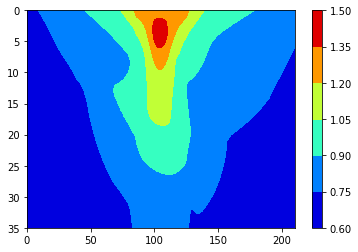

In [317]:
plt.contourf(tau_pred)
plt.gca().invert_yaxis()
plt.colorbar()

In [318]:
T0_star1 = T0_star[(21*len(X_predict)): 22* len(X_predict),:]
T0_star1 = np.reshape(T0_star1, (36, 211))

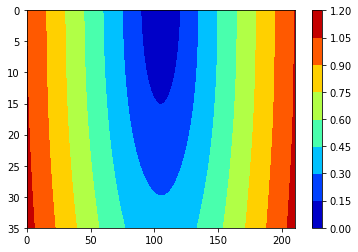

In [319]:
plt.contourf(T0_star1)
plt.gca().invert_yaxis()
plt.colorbar()

In [320]:
Tpred = tau_pred*T0_star1

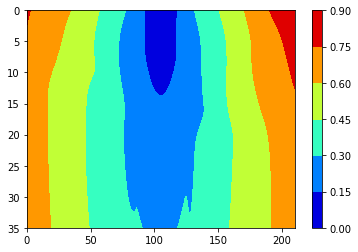

In [321]:
plt.contourf(Tpred)
plt.gca().invert_yaxis()
plt.colorbar()

In [158]:
fmmtravel = pd.read_csv('/content/drive/MyDrive/pinn_new_test_models/traveltime_midshot.csv',header=None)
fmmtravel = fmmtravel.values

In [61]:
fmmtravel = pd.read_csv('/content/drive/MyDrive/pinn_new_test_models/t_test.csv',header=None)
fmmtravel = fmmtravel.values

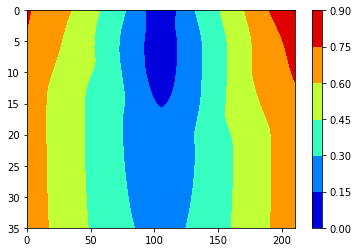

In [159]:
plt.contourf(fmmtravel)
plt.gca().invert_yaxis()
plt.colorbar()

In [ ]:
#t_test = pd.read_csv('/content/drive/MyDrive/pinn_new_test_models/t_test.csv',header=None)
#t_test = t_test.values

Text(0, 0.5, 'Loss')

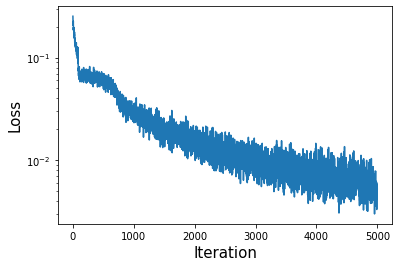

In [82]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
plt.plot(saved_loss[0:10000])
ax.set_yscale('log')
plt.xlabel('Iteration',  fontsize=15)
plt.ylabel('Loss',  fontsize=15)

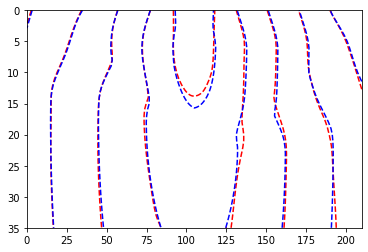

In [43]:
plt.contour(Tpred, colors='r', linestyles = 'dashed')
plt.contour(fmmtravel,colors='b',linestyles = 'dashed' )
plt.gca().invert_yaxis()

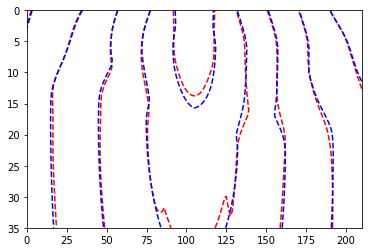

In [322]:
plt.contour(Tpred, colors='r', linestyles = 'dashed')
plt.contour(fmmtravel,colors='b',linestyles = 'dashed')
plt.gca().invert_yaxis()


In [323]:
CV_star = CV_star[0:len(X_predict),:]
CV_star = np.reshape(CV_star, (36, 211))


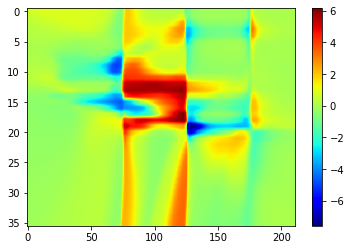

In [324]:
plt.imshow(CV_star, aspect='auto' )
plt.colorbar()

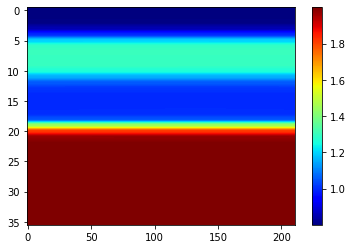

In [47]:
plt.imshow(CV_star, aspect='auto' )
plt.colorbar()
#plt.clim(0.8,2.0)

In [46]:
velocity_model = pd.read_csv('/content/drive/MyDrive/pinn_new_test_models/new_modelexamp4.csv',header=None)
velocity_model = velocity_model.values

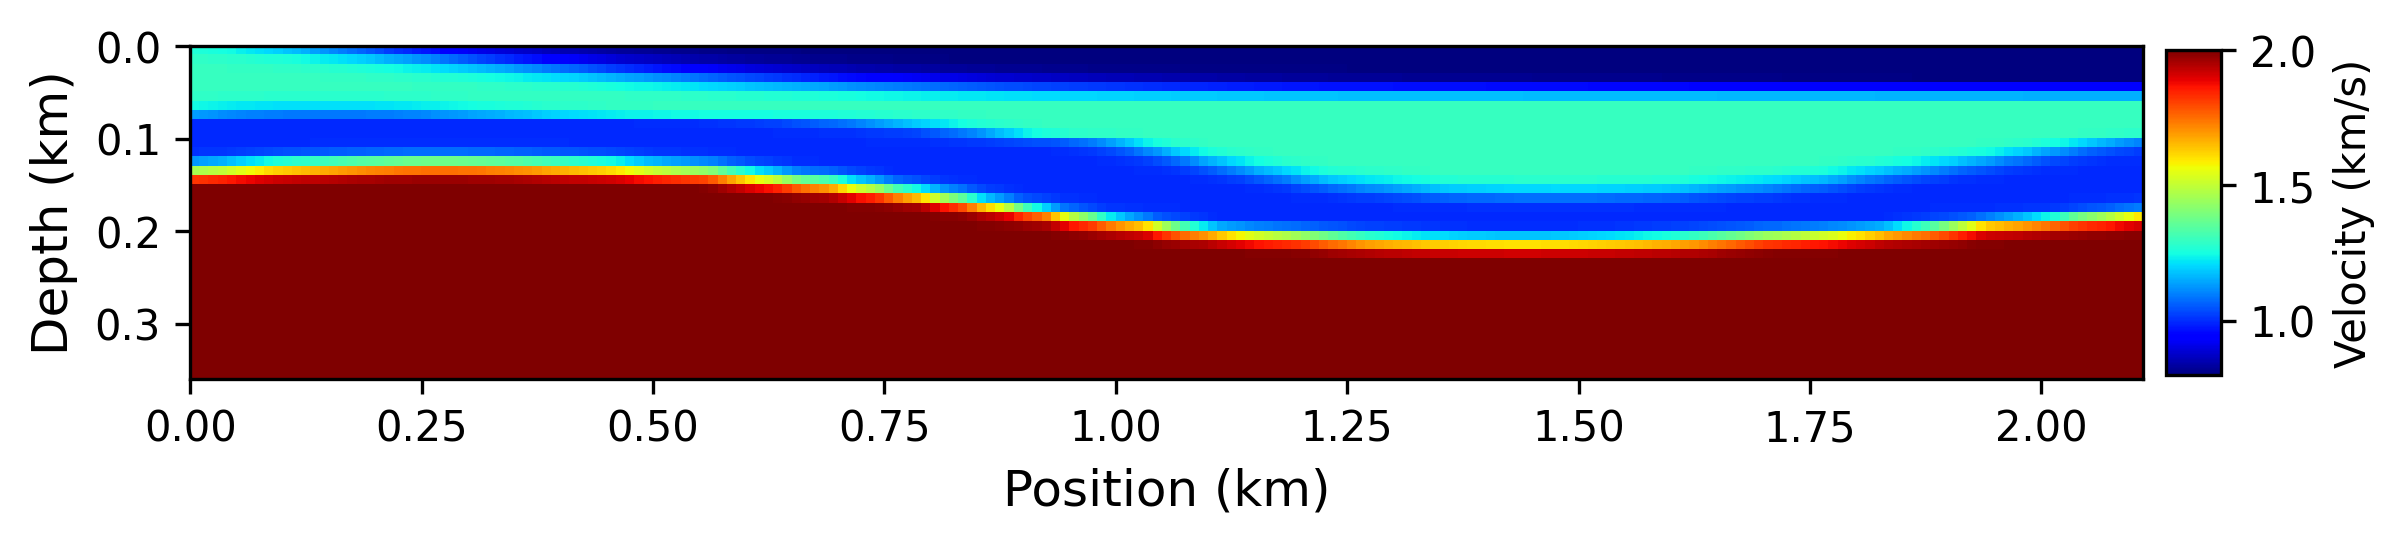

In [47]:
fig = plt.figure(figsize=(10,7), dpi=300)
plt.imshow(velocity_model, extent = [0 ,2.11 , 0.36, 0])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.yticks((0,0.1,0.2,0.3))
plt.xlabel('Position (km)',  fontsize=12)
plt.ylabel('Depth (km)',  fontsize=12)
plt.clim(0.8,2.0)
cbar=plt.colorbar(pad=0.01,aspect=6,shrink=0.205)
cbar.set_label('Velocity (km/s)', rotation=90, size=10)
cbar.ax.tick_params(labelsize=10)
plt.show()

In [44]:
well_middle = velocity_model[:,105]

In [45]:
v_Z = np.array([well_middle ,]*211).transpose()

In [67]:
velocity_prediction = CV_star * v_Z

In [ ]:
# with well constraint

In [442]:
X_dis = 1.05 - X_m

In [443]:
velocity_pred = v_Z  + X_dis * CV_star

In [ ]:
# three well

In [358]:
X_dis1 = 0.5 - X_m
X_dis2 = 1.05 - X_m
X_dis3 = 1.5 - X_m

In [ ]:
# four well

In [325]:
X_dis1 = 0.25 - X_m
X_dis2 = 0.75 - X_m
X_dis3 = 1.25 - X_m
X_dis4 = 1.75 - X_m

In [359]:
velocity_pred = three_well + X_dis1 * X_dis2 * X_dis3 * CV_star

In [326]:
velocity_pred = four_well + X_dis1 * X_dis2 * X_dis3 * X_dis4 * CV_star

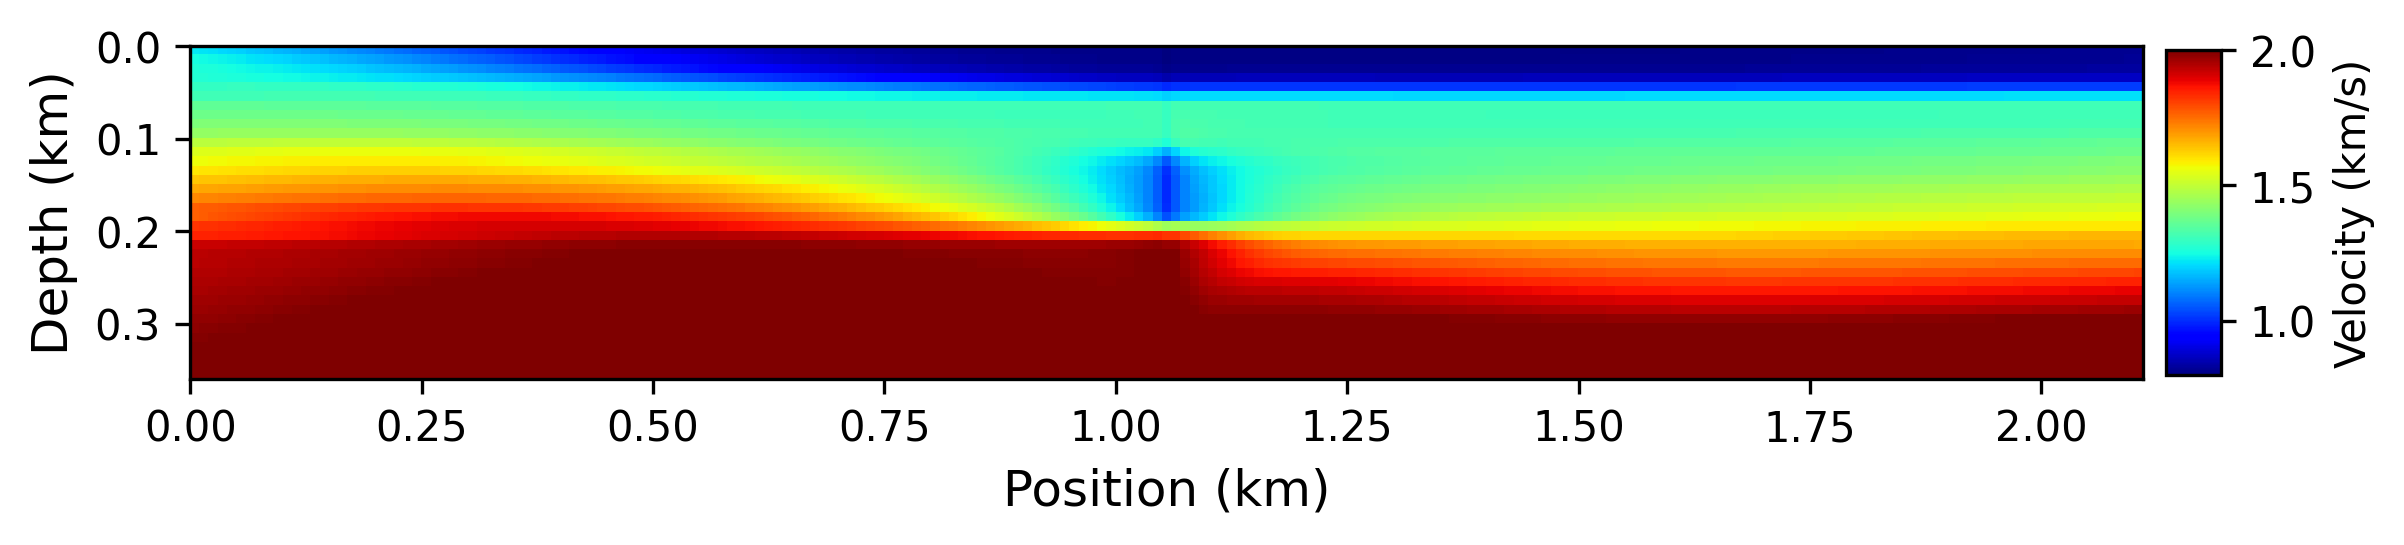

In [444]:
fig = plt.figure(figsize=(10,7), dpi=300)
plt.imshow(velocity_pred, extent = [0 ,2.11 , 0.36, 0])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.yticks((0,0.1,0.2,0.3))
plt.xlabel('Position (km)',  fontsize=12)
plt.ylabel('Depth (km)',  fontsize=12)
plt.clim(0.8,2.0)
cbar=plt.colorbar(pad=0.01,aspect=6,shrink=0.205)
cbar.set_label('Velocity (km/s)', rotation=90, size=10)
cbar.ax.tick_params(labelsize=10)
plt.show()

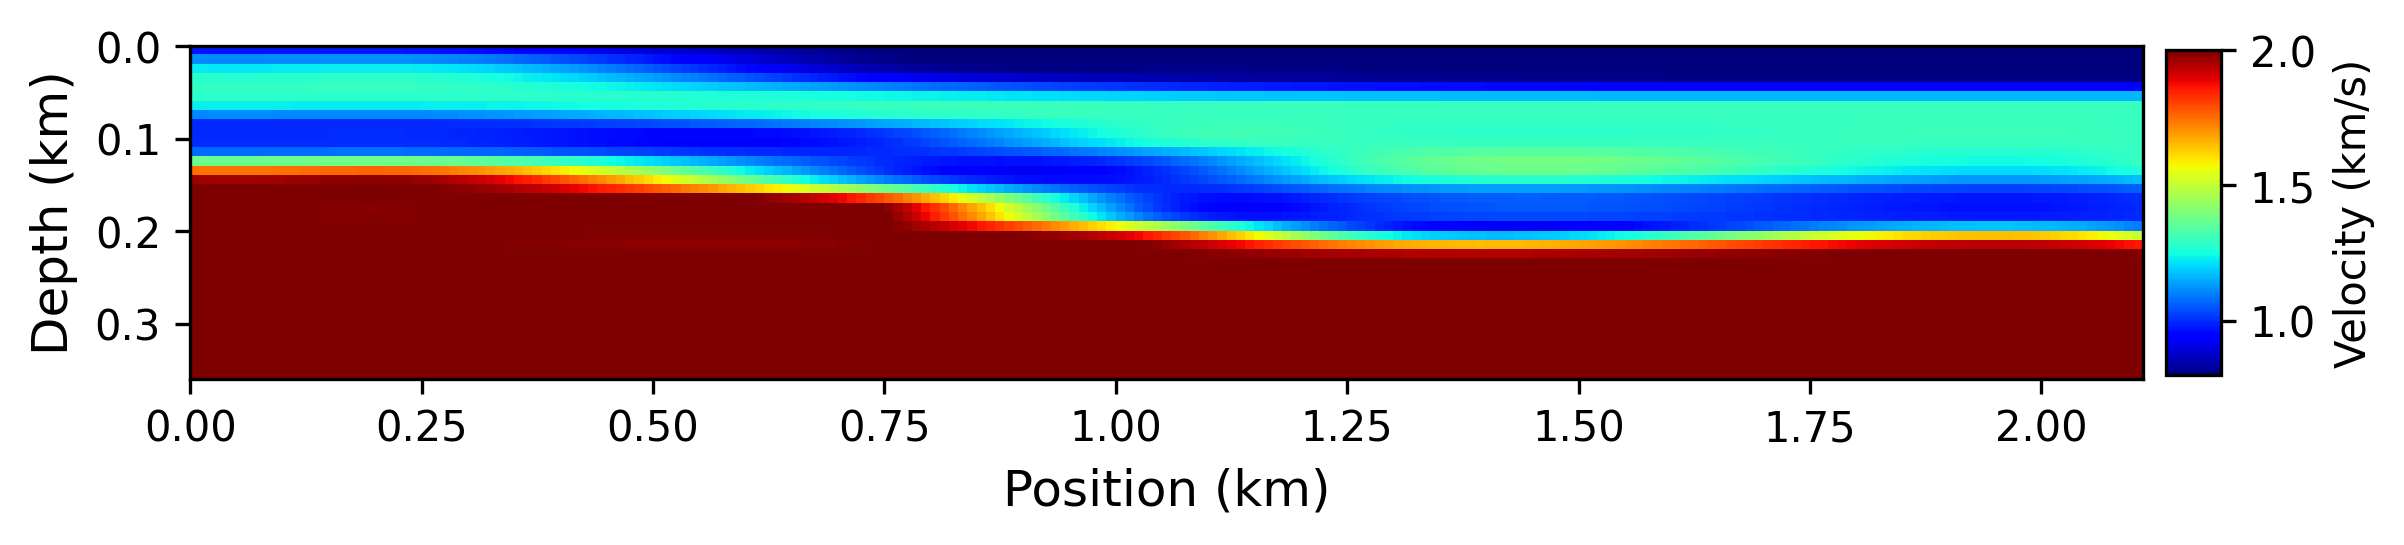

In [52]:
fig = plt.figure(figsize=(10,7), dpi=300)
plt.imshow(four_well, extent = [0 ,2.11 , 0.36, 0])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.yticks((0,0.1,0.2,0.3))
plt.xlabel('Position (km)',  fontsize=12)
plt.ylabel('Depth (km)',  fontsize=12)
plt.clim(0.8,2.0)
cbar=plt.colorbar(pad=0.01,aspect=6,shrink=0.205)
cbar.set_label('Velocity (km/s)', rotation=90, size=10)
cbar.ax.tick_params(labelsize=10)
plt.show()

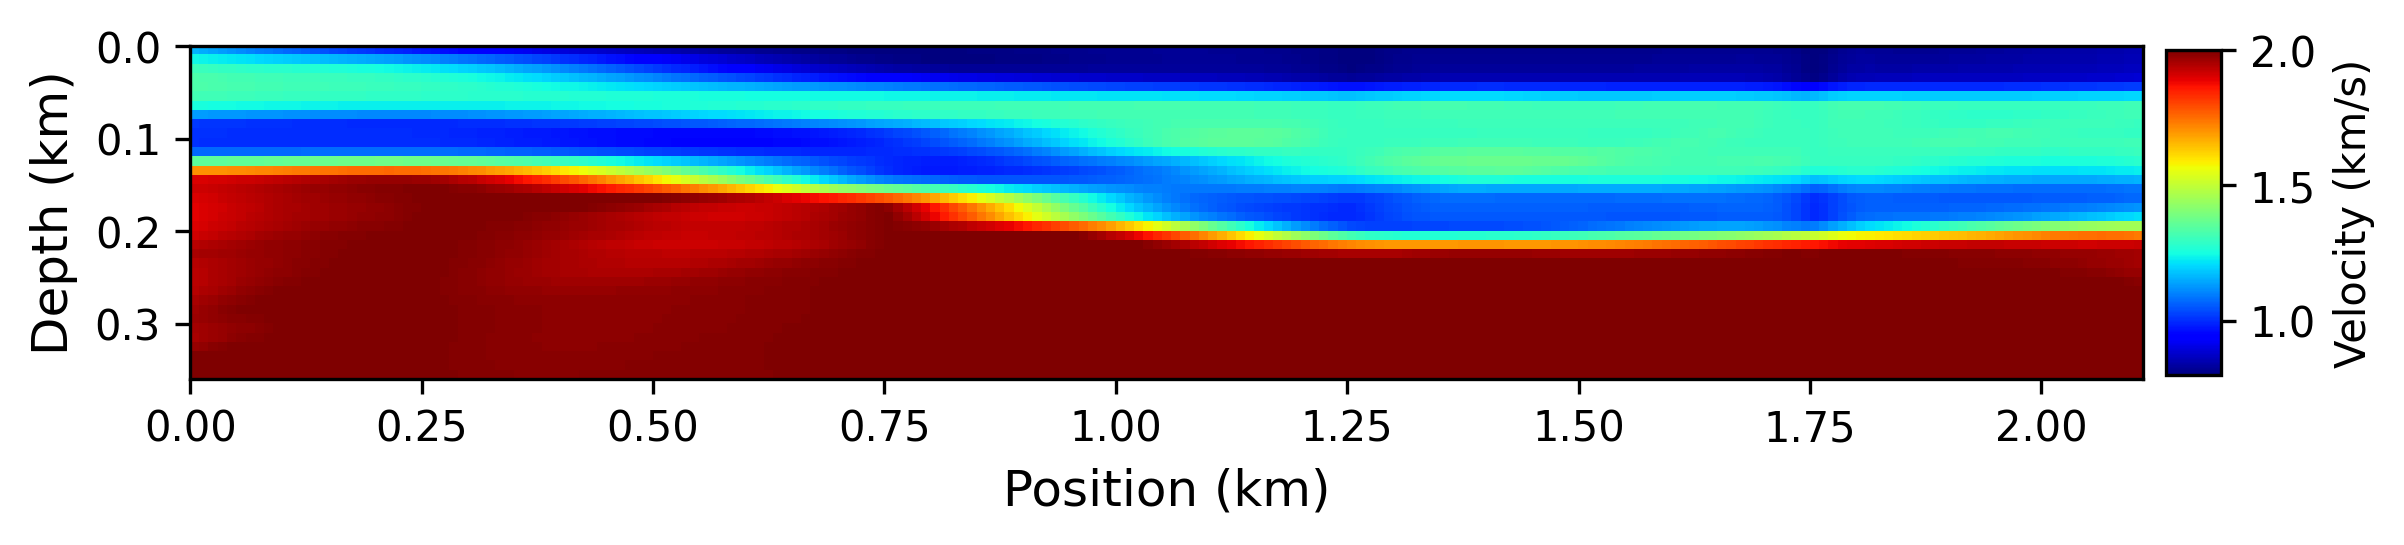

In [207]:
fig = plt.figure(figsize=(10,7), dpi=300)
plt.imshow(velocity_pred, extent = [0 ,2.11 , 0.36, 0])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.yticks((0,0.1,0.2,0.3))
plt.xlabel('Position (km)',  fontsize=12)
plt.ylabel('Depth (km)',  fontsize=12)
plt.clim(0.8,2.0)
cbar=plt.colorbar(pad=0.01,aspect=6,shrink=0.205)
cbar.set_label('Velocity (km/s)', rotation=90, size=10)
cbar.ax.tick_params(labelsize=10)
plt.show()

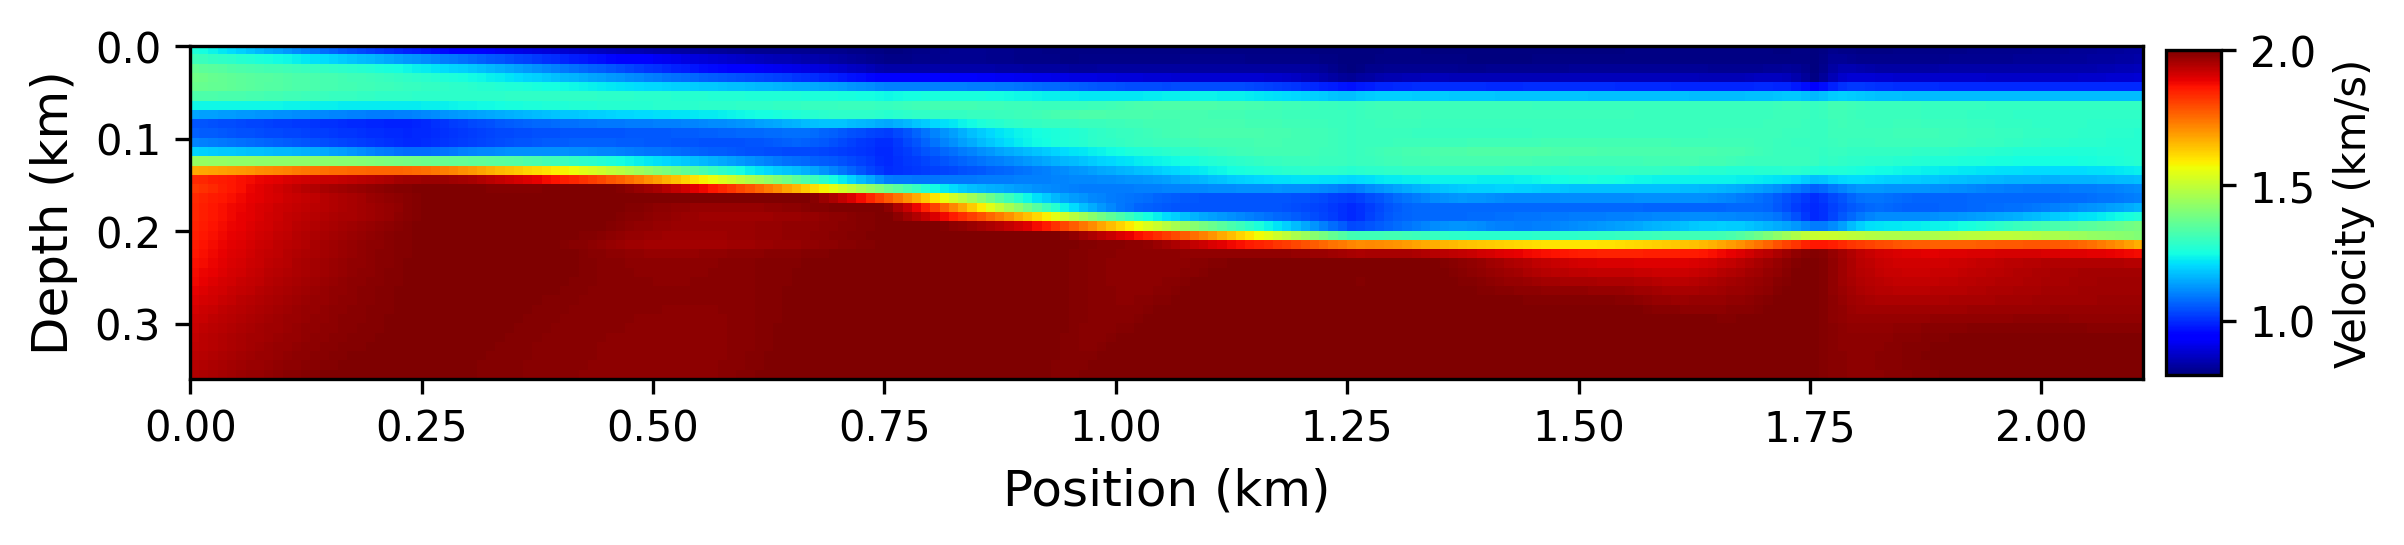

In [327]:
fig = plt.figure(figsize=(10,7), dpi=300)
plt.imshow(velocity_pred, extent = [0 ,2.11 , 0.36, 0])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.yticks((0,0.1,0.2,0.3))
plt.xlabel('Position (km)',  fontsize=12)
plt.ylabel('Depth (km)',  fontsize=12)
plt.clim(0.8,2.0)
cbar=plt.colorbar(pad=0.01,aspect=6,shrink=0.205)
cbar.set_label('Velocity (km/s)', rotation=90, size=10)
cbar.ax.tick_params(labelsize=10)
plt.show()

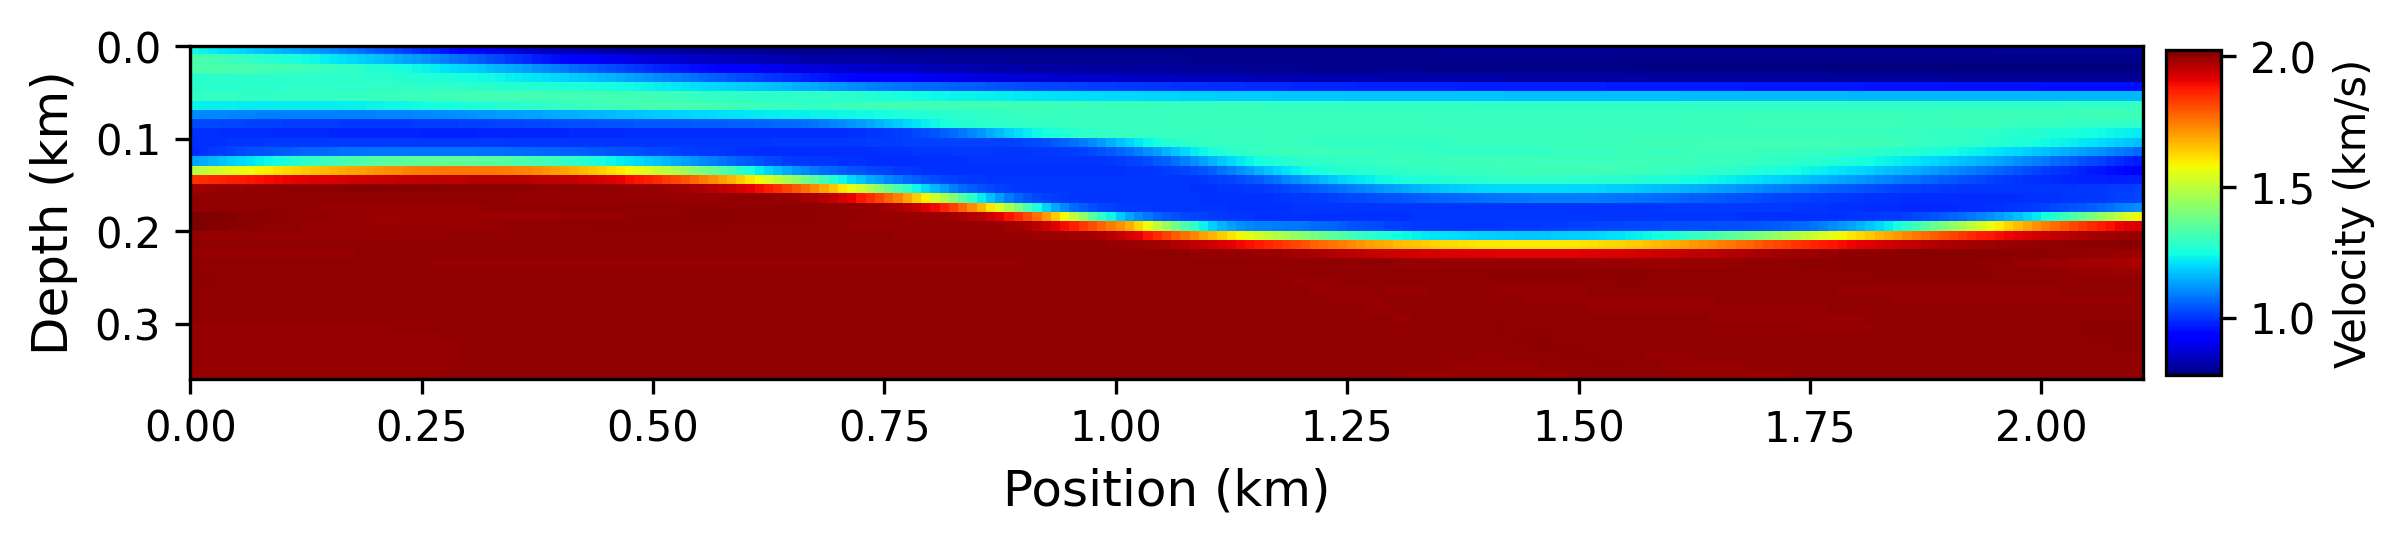

In [ ]:
fig = plt.figure(figsize=(10,7), dpi=300)
plt.imshow(velocity_pred, extent = [0 ,2.11 , 0.36, 0])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.yticks((0,0.1,0.2,0.3))
plt.xlabel('Position (km)',  fontsize=12)
plt.ylabel('Depth (km)',  fontsize=12)
#plt.clim(0.8,2.0)
cbar=plt.colorbar(pad=0.01,aspect=6,shrink=0.205)
cbar.set_label('Velocity (km/s)', rotation=90, size=10)
cbar.ax.tick_params(labelsize=10)
plt.show()

In [ ]:
pd.DataFrame(velocity_pred).to_csv("/content/drive/MyDrive/pinn_new_test_models/"+'inversion_test.csv', header=None, index=None)


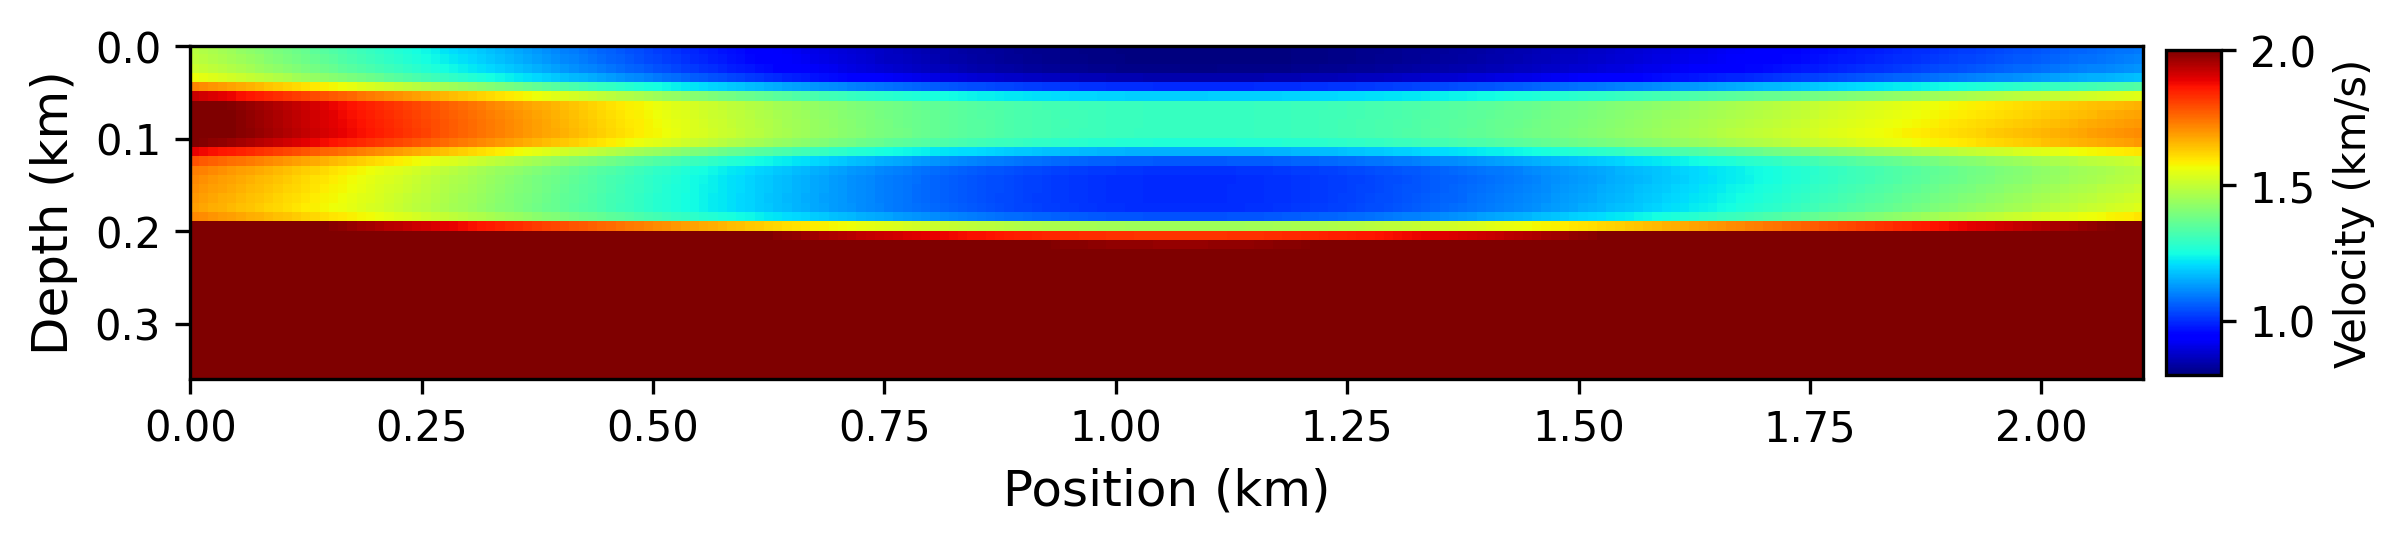

In [ ]:
fig = plt.figure(figsize=(10,7), dpi=300)
plt.imshow(velocity_pred, extent = [0 ,2.11 , 0.36, 0])
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.yticks((0,0.1,0.2,0.3))
plt.xlabel('Position (km)',  fontsize=12)
plt.ylabel('Depth (km)',  fontsize=12)
plt.clim(0.8,2.0)
cbar=plt.colorbar(pad=0.01,aspect=6,shrink=0.205)
cbar.set_label('Velocity (km/s)', rotation=90, size=10)
cbar.ax.tick_params(labelsize=10)
plt.show()

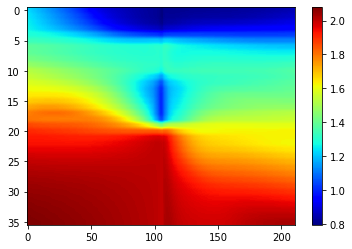

In [ ]:
plt.imshow(velocity_pred, aspect='auto' )
plt.colorbar()
#plt.clim(0.8,2.0)

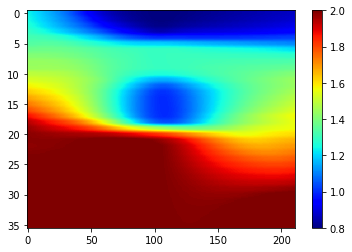

In [ ]:
plt.imshow(velocity_pred, aspect='auto' )
plt.colorbar()
plt.clim(0.8,2.0)

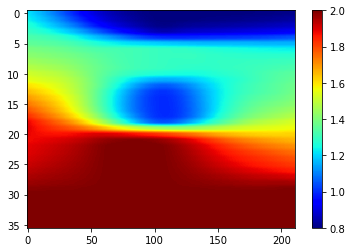

In [ ]:
plt.imshow(velocity_pred, aspect='auto' )
plt.colorbar()
plt.clim(0.8,2.0)